In [24]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 


import xgboost as xgb 
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy import stats



In [2]:
df=pd.read_csv('PJMW_hourly.csv')
df=df.set_index('Datetime')
df.index=pd.to_datetime(df.index)
df.head()

,PJMW_MW
Datetime,
2002-12-31 01:00:00,5077.0
2002-12-31 02:00:00,4939.0
2002-12-31 03:00:00,4885.0
2002-12-31 04:00:00,4857.0
2002-12-31 05:00:00,4930.0


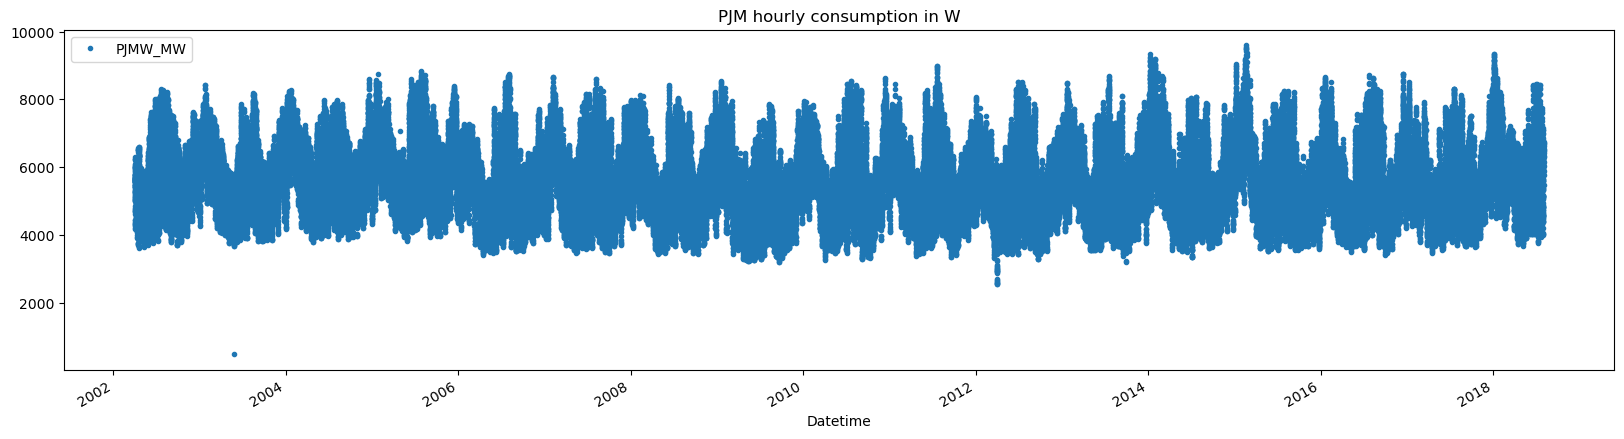

In [3]:
df.plot(style='.',
figsize=(20,5),title="PJM hourly consumption in W")
plt.show()

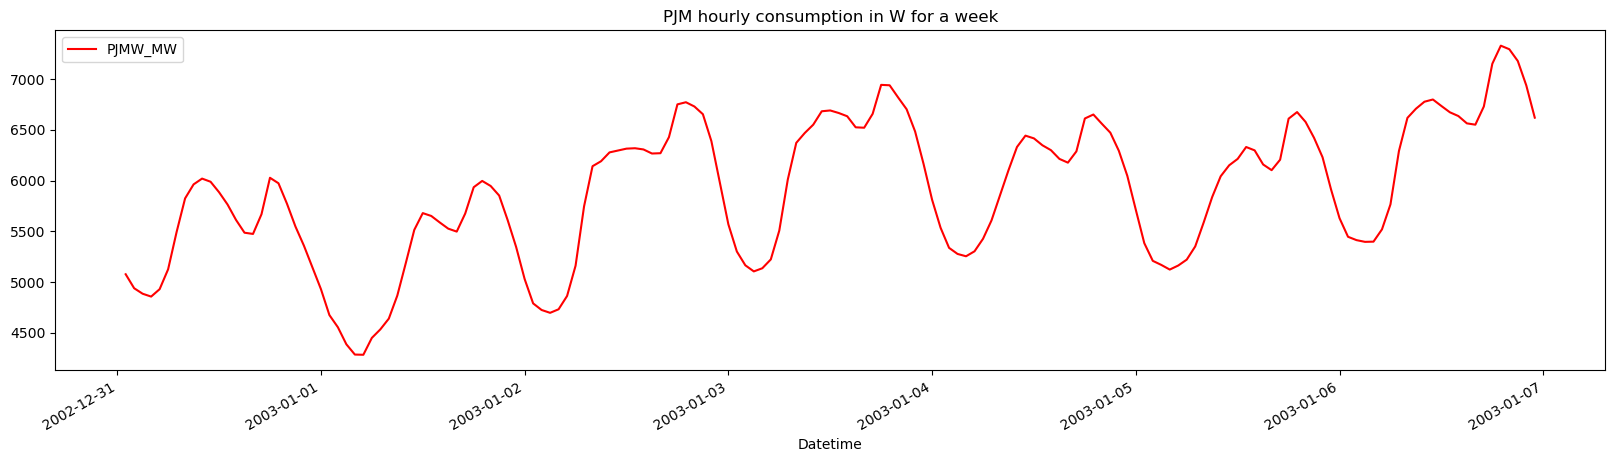

In [96]:
df_weekly=df.loc[(df.index>'2002-12-31') & (df.index<'2003-01-7')].copy()
df_weekly.plot(figsize=(20,5),color='r',title="PJM hourly consumption in W for a week")
plt.show()


Removing outliers 

In [9]:
z=abs(stats.zscore(df['PJMW_MW']))
threshold=3
outliers=df[z>threshold]
df=df.drop(outliers.index)

Create features 

In [10]:
def createFeature(df):
    df=df.copy()
    df['year']=df.index.year
    df['month']=df.index.month
    df['day_of_week']=df.index.dayofweek
    df['day_of_year']=df.index.dayofyear
    df['quarter']=df.index.quarter
    df['hour']=df.index.hour
    return df


In [11]:
df=createFeature(df)

In [12]:
df.head()

,PJMW_MW,year,month,day_of_week,day_of_year,quarter,hour
Datetime,,,,,,,
2002-12-31 01:00:00,5077.0,2002,12,1,365,4,1
2002-12-31 02:00:00,4939.0,2002,12,1,365,4,2
2002-12-31 03:00:00,4885.0,2002,12,1,365,4,3
2002-12-31 04:00:00,4857.0,2002,12,1,365,4,4
2002-12-31 05:00:00,4930.0,2002,12,1,365,4,5


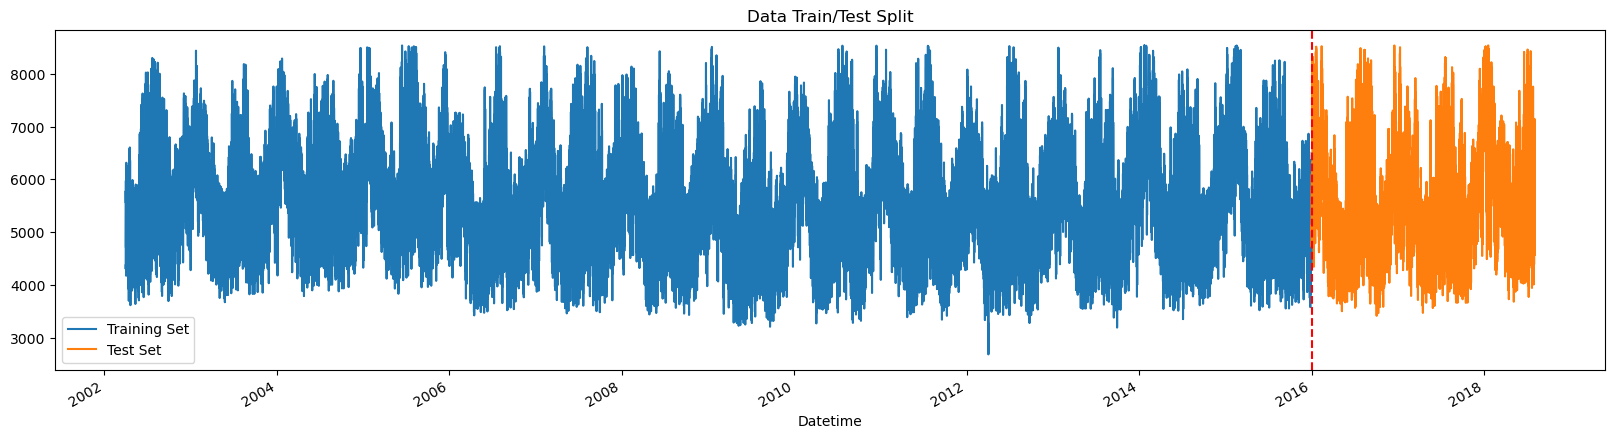

In [13]:
train,test=df.loc[df.index<'2016-01-01'],df.loc[df.index>='2016-01-01']
fig, ax = plt.subplots(figsize=(20, 5))
train['PJMW_MW'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['PJMW_MW'].plot(ax=ax, label='Test Set')
ax.axvline('2016-01-01',color='red',ls='--')
ax.legend()

Visualizing feature/target relationship

In [14]:
features=list(df.columns)
features=features[1:]
target='PJMW_MW'

c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Categorica

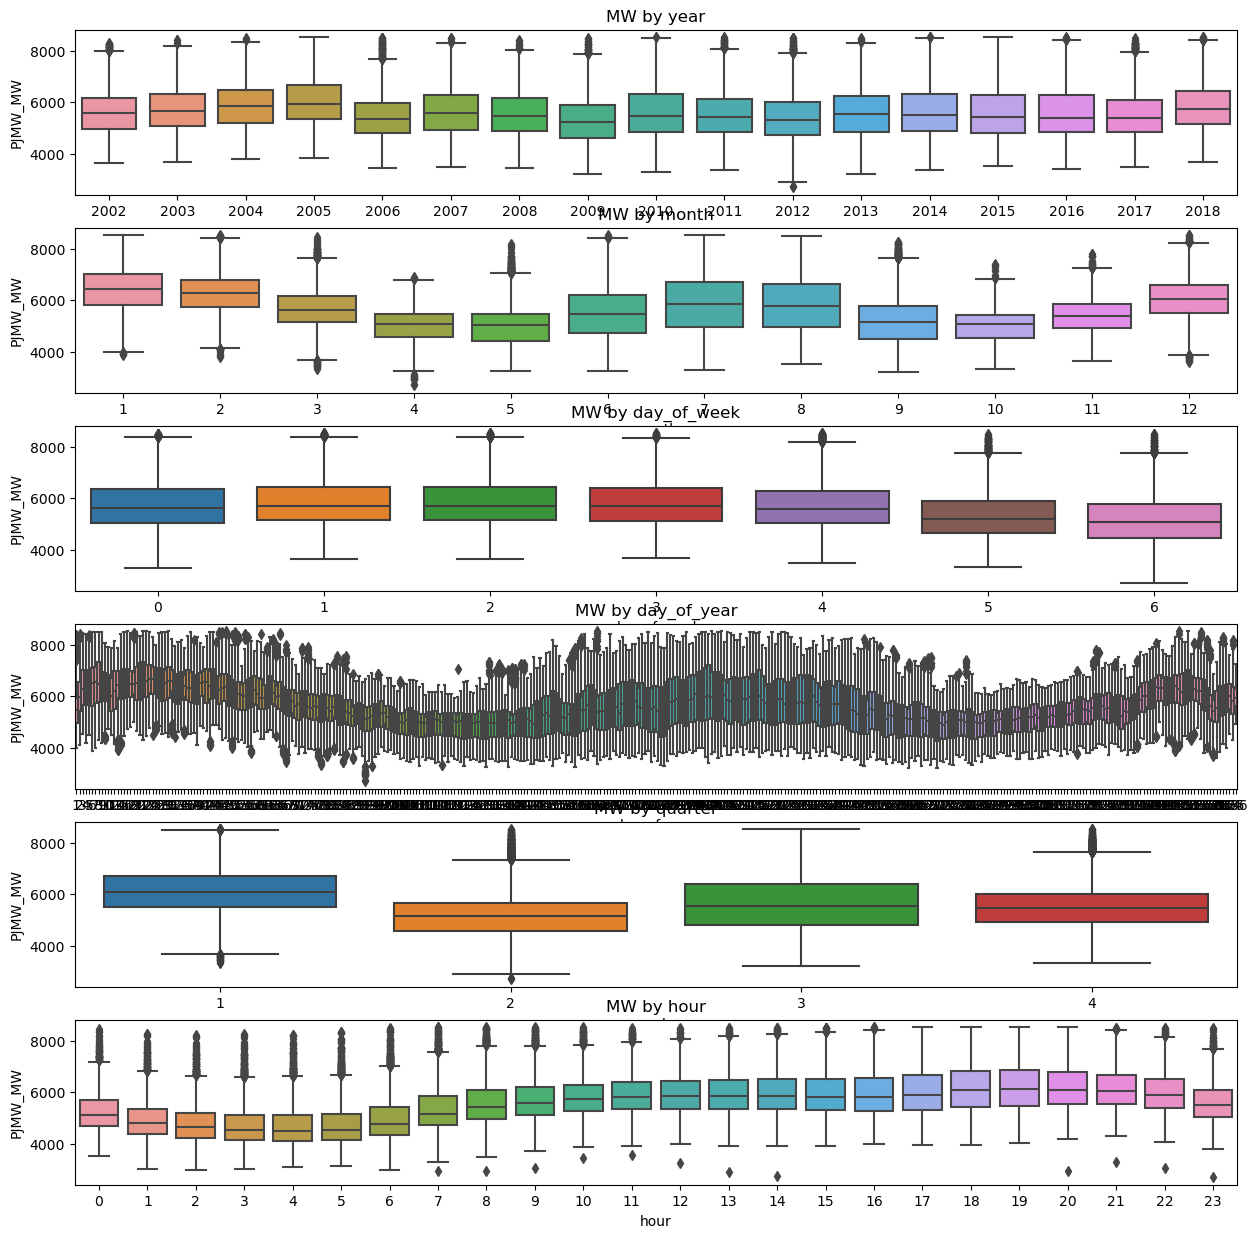

In [15]:
fig, ax = plt.subplots(len(features),figsize=(15, 15))
for i in range(len(features)):
    sns.boxplot(data=df, x=features[i], y=target,ax=ax[i])
    ax[i].set_title('MW by '+features[i])

plt.show()



In [16]:
X_train,y_train=train[features],train[target]
X_test,y_test=test[features],test[target]

Prediction with XGBOOST

In [17]:
model=xgb.XGBRegressor(n_estimators=1000,booster='gbtree',early_stopping_rounds=50,learning_rate=0.01)
model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=10)

[0]	validation_0-rmse:5621.41596	validation_1-rmse:5628.64451


c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[10]	validation_0-rmse:5090.04128	validation_1-rmse:5088.82497
[20]	validation_0-rmse:4610.06387	validation_1-rmse:4602.28101
[30]	validation_0-rmse:4176.47162	validation_1-rmse:4163.18777
[40]	validation_0-rmse:3785.04999	validation_1-rmse:3769.45809
[50]	validation_0-rmse:3431.71152	validation_1-rmse:3415.40433
[60]	validation_0-rmse:3112.37546	validation_1-rmse:3095.48721
[70]	validation_0-rmse:2824.42661	validation_1-rmse:2809.35400
[80]	validation_0-rmse:2564.99944	validation_1-rmse:2553.16868
[90]	validation_0-rmse:2331.22954	validation_1-rmse:2323.37097
[100]	validation_0-rmse:2120.62803	validation_1-rmse:2117.29670
[110]	validation_0-rmse:1930.94366	validation_1-rmse:1933.30508
[120]	validation_0-rmse:1760.38716	validation_1-rmse:1769.00256
[130]	validation_0-rmse:1607.19126	validation_1-rmse:1622.76761
[140]	validation_0-rmse:1469.84645	validation_1-rmse:1493.80918
[150]	validation_0-rmse:1346.77466	validation_1-rmse:1380.63497
[160]	validation_0-rmse:1236.32972	validation_1-r

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

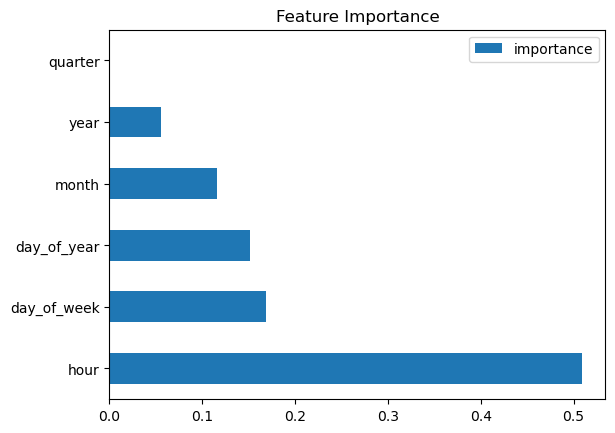

In [18]:
featImportance=pd.DataFrame(data=model.feature_importances_,index=model.feature_names_in_,columns=['importance'])
featImportance.sort_values(by='importance',ascending=False).plot(kind='barh',title='Feature Importance')
plt.show()

c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

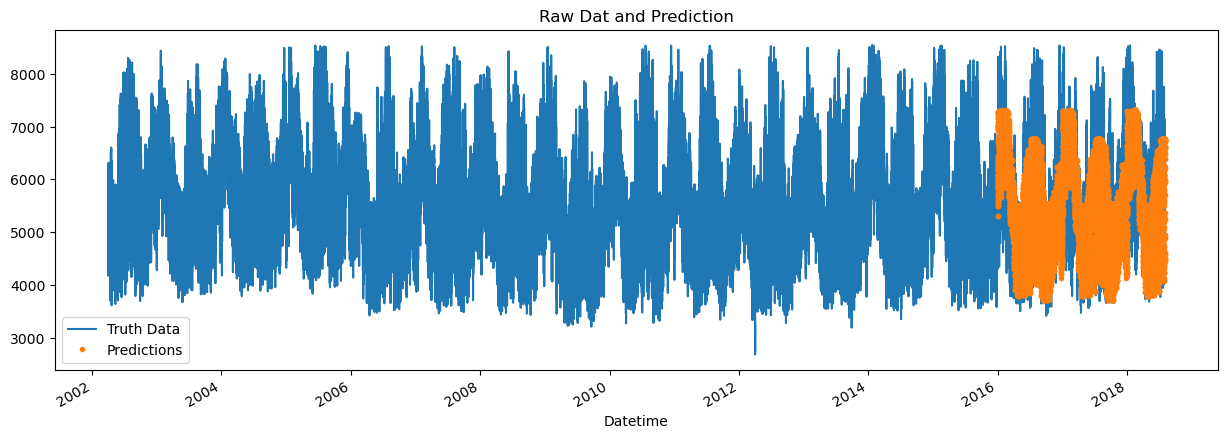

In [19]:
test['xgb_prediction']=model.predict(X_test)
df=df.merge(test['xgb_prediction'],how='left',left_index=True,right_index=True)
ax = df[[target]].plot(figsize=(15, 5))
df['xgb_prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()



In [20]:
test['xgb_error']=abs(test[target]-test['xgb_prediction'])

In [21]:
rmse=np.sqrt(mean_squared_error(test[target],test['xgb_prediction']))
print("The root mean squared error is ",rmse)

The root mean squared error is  704.8706298648378


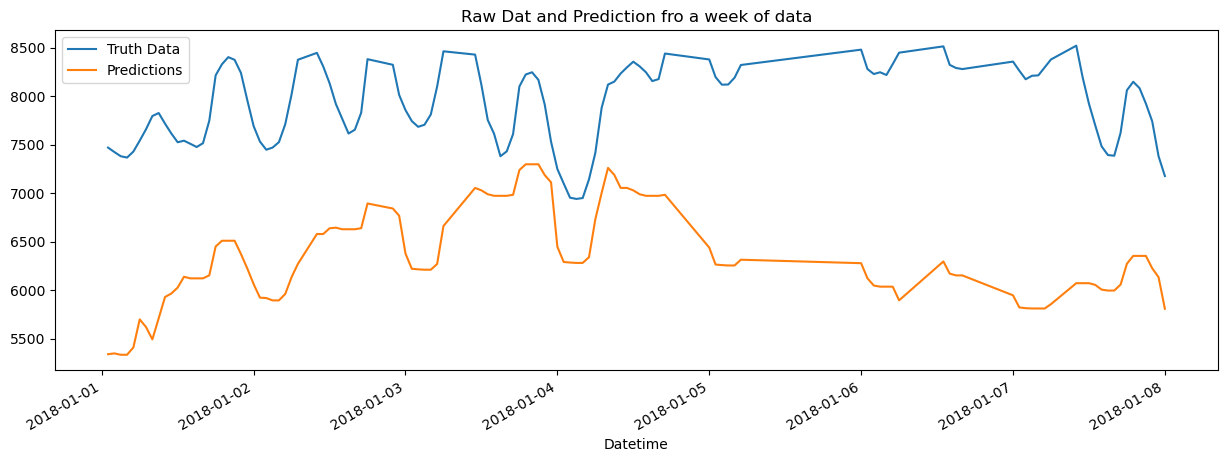

In [22]:
df_week=df.loc[(df.index<='2018-01-08') & (df.index>'2018-01-01')].copy()
ax =df_week[target].plot(figsize=(15, 5))
df_week['xgb_prediction'].plot(ax=ax, style='-')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction fro a week of data')
plt.show()

In [23]:
test['date']=test.index.date
test.groupby(['date'])['xgb_error'].mean().sort_values(ascending=False).head(10)

date
2017-12-31    2764.394999
2017-12-28    2409.412760
2017-12-29    2357.152039
2017-12-30    2235.839233
2016-12-16    2224.460307
2018-01-06    2218.397683
2017-02-24    2109.503499
2017-02-25    2058.290304
2018-01-07    1930.303688
2018-01-05    1922.301676
Name: xgb_error, dtype: float64

Using Cross validation and introducing lags

In [36]:
#Cross validation

n_test_years=1
tss=TimeSeriesSplit(n_splits=5, test_size=24*364*n_test_years, gap=24)
df=df.sort_index()

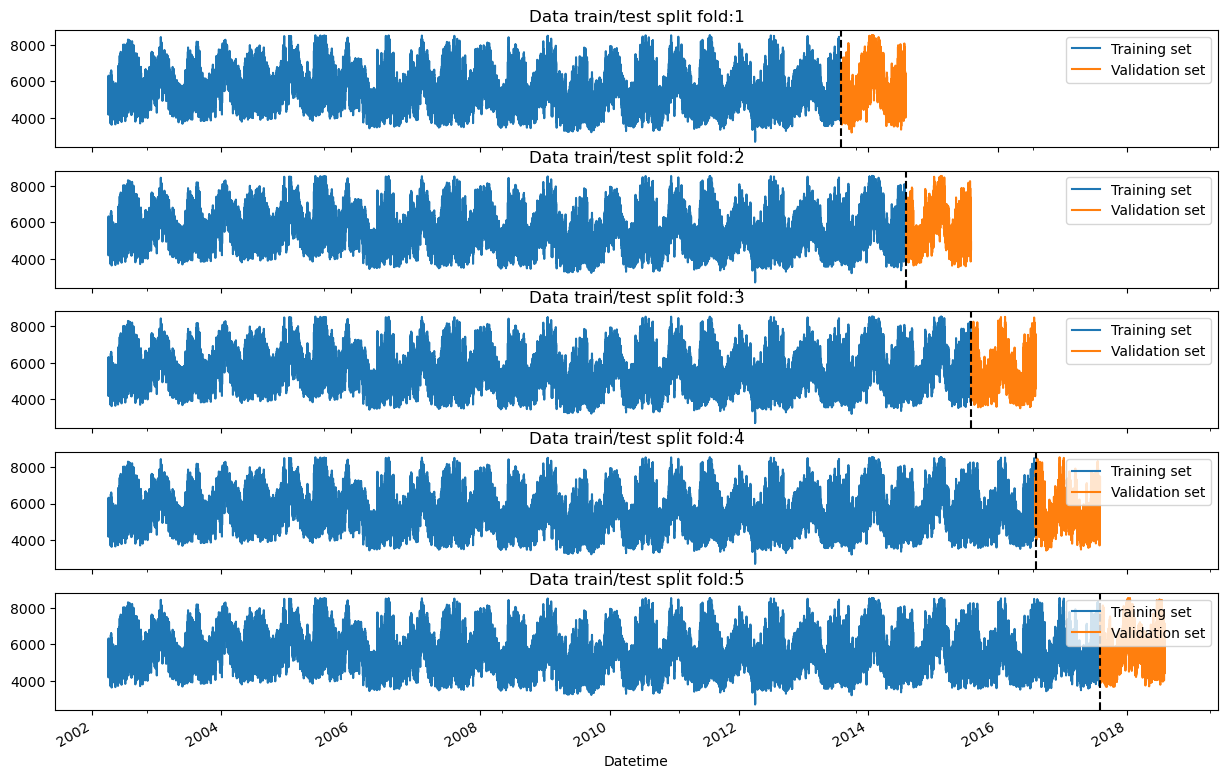

In [37]:
fig,axs=plt.subplots(5,figsize=(15,10),sharex=True)
fold=0

for train_idx,val_idx in tss.split(df):
    train=df.iloc[train_idx]
    test=df.iloc[val_idx]
    train['PJMW_MW'].plot(ax=axs[fold],label="Training set",title=f'Data train/test split fold number {fold}')
    test['PJMW_MW'].plot(ax=axs[fold],label="Test set",title=f'Data train/test split fold:{fold+1}')
    axs[fold].axvline(test.index.min(),color= "black",ls="--")
    axs[fold].legend(["Training set","Validation set"])
    fold+=1
    

plt.show()

In [38]:
def addLags(df):
    df=df.copy()
    target_map=df[target].to_dict()
    df['lag1']=(df.index-pd.Timedelta("364 days")).map(target_map)
    df['lag2']=(df.index-pd.Timedelta("728 days")).map(target_map)
    df['lag3']=(df.index-pd.Timedelta("1092 days")).map(target_map)
    return df 
df= addLags(df)

[23:14:44] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5673.81102	validation_1-rmse:5705.56326


c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[100]	validation_0-rmse:5139.48031	validation_1-rmse:5185.45150
[200]	validation_0-rmse:4656.49243	validation_1-rmse:4715.36814
[300]	validation_0-rmse:4219.97652	validation_1-rmse:4289.51608
[400]	validation_0-rmse:3825.55498	validation_1-rmse:3903.96124
[500]	validation_0-rmse:3469.27319	validation_1-rmse:3555.95097
[600]	validation_0-rmse:3147.54828	validation_1-rmse:3242.72811
[700]	validation_0-rmse:2857.03062	validation_1-rmse:2959.37873
[800]	validation_0-rmse:2594.90341	validation_1-rmse:2703.65519
[900]	validation_0-rmse:2358.48736	validation_1-rmse:2473.07640
[1000]	validation_0-rmse:2145.40876	validation_1-rmse:2265.59854
[1100]	validation_0-rmse:1953.45411	validation_1-rmse:2079.05650
[1200]	validation_0-rmse:1780.66818	validation_1-rmse:1911.62898
[1300]	validation_0-rmse:1625.28868	validation_1-rmse:1761.89586
[1400]	validation_0-rmse:1485.87715	validation_1-rmse:1627.76009
[1500]	validation_0-rmse:1360.92689	validation_1-rmse:1507.75440
[1600]	validation_0-rmse:1249.0380

c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[23:18:03] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5676.36547	validation_1-rmse:5774.67539


c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[100]	validation_0-rmse:5141.86090	validation_1-rmse:5250.83999
[200]	validation_0-rmse:4658.74160	validation_1-rmse:4777.48524
[300]	validation_0-rmse:4222.09984	validation_1-rmse:4349.14333
[400]	validation_0-rmse:3827.60488	validation_1-rmse:3961.64327
[500]	validation_0-rmse:3471.25592	validation_1-rmse:3610.87120
[600]	validation_0-rmse:3149.49734	validation_1-rmse:3294.12659
[700]	validation_0-rmse:2859.05200	validation_1-rmse:3008.41745
[800]	validation_0-rmse:2596.94735	validation_1-rmse:2750.22711
[900]	validation_0-rmse:2360.55329	validation_1-rmse:2516.88458
[1000]	validation_0-rmse:2147.53771	validation_1-rmse:2305.67438
[1100]	validation_0-rmse:1955.71950	validation_1-rmse:2114.85005
[1200]	validation_0-rmse:1783.12967	validation_1-rmse:1944.17000
[1300]	validation_0-rmse:1627.97100	validation_1-rmse:1789.92376
[1400]	validation_0-rmse:1488.75520	validation_1-rmse:1651.43816
[1500]	validation_0-rmse:1364.04795	validation_1-rmse:1528.00070
[1600]	validation_0-rmse:1252.4346

c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[23:20:49] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5683.65384	validation_1-rmse:5515.91903


c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[100]	validation_0-rmse:5148.49747	validation_1-rmse:4977.90015
[200]	validation_0-rmse:4664.78628	validation_1-rmse:4491.55078
[300]	validation_0-rmse:4227.64725	validation_1-rmse:4052.19445
[400]	validation_0-rmse:3832.70910	validation_1-rmse:3656.50078
[500]	validation_0-rmse:3475.95101	validation_1-rmse:3299.62615
[600]	validation_0-rmse:3153.84866	validation_1-rmse:2977.21432
[700]	validation_0-rmse:2863.06995	validation_1-rmse:2686.18987
[800]	validation_0-rmse:2600.64545	validation_1-rmse:2424.41112
[900]	validation_0-rmse:2364.01342	validation_1-rmse:2188.86366
[1000]	validation_0-rmse:2150.77234	validation_1-rmse:1976.70301
[1100]	validation_0-rmse:1958.80234	validation_1-rmse:1786.79175
[1200]	validation_0-rmse:1786.16331	validation_1-rmse:1616.31136
[1300]	validation_0-rmse:1631.04989	validation_1-rmse:1464.09999
[1400]	validation_0-rmse:1491.80577	validation_1-rmse:1328.63669
[1500]	validation_0-rmse:1366.89407	validation_1-rmse:1210.34081
[1600]	validation_0-rmse:1255.1764

c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[23:22:40] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5672.08453	validation_1-rmse:5600.81683


c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[100]	validation_0-rmse:5138.16926	validation_1-rmse:5075.87478
[200]	validation_0-rmse:4655.59593	validation_1-rmse:4600.79273
[300]	validation_0-rmse:4219.52339	validation_1-rmse:4171.57547
[400]	validation_0-rmse:3825.55322	validation_1-rmse:3784.40374
[500]	validation_0-rmse:3469.71311	validation_1-rmse:3436.06206
[600]	validation_0-rmse:3148.43780	validation_1-rmse:3121.90670
[700]	validation_0-rmse:2858.47553	validation_1-rmse:2837.87940
[800]	validation_0-rmse:2596.81404	validation_1-rmse:2581.69897
[900]	validation_0-rmse:2360.91786	validation_1-rmse:2351.57736
[1000]	validation_0-rmse:2148.37982	validation_1-rmse:2145.55465
[1100]	validation_0-rmse:1957.07101	validation_1-rmse:1961.15472
[1200]	validation_0-rmse:1785.04395	validation_1-rmse:1796.19044
[1300]	validation_0-rmse:1630.55253	validation_1-rmse:1648.41434
[1400]	validation_0-rmse:1491.93693	validation_1-rmse:1517.03559
[1500]	validation_0-rmse:1367.68826	validation_1-rmse:1401.54571
[1600]	validation_0-rmse:1256.5007

c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[23:25:34] WARNING: c:\users\dev-admin\croot2\xgboost-split_1675461376218\work\src\objective\regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:5667.51399	validation_1-rmse:5758.74213


c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

[100]	validation_0-rmse:5134.19642	validation_1-rmse:5232.75108
[200]	validation_0-rmse:4652.18896	validation_1-rmse:4757.88747
[300]	validation_0-rmse:4216.64856	validation_1-rmse:4328.04892
[400]	validation_0-rmse:3823.15982	validation_1-rmse:3939.92165
[500]	validation_0-rmse:3467.81479	validation_1-rmse:3589.43580
[600]	validation_0-rmse:3147.02271	validation_1-rmse:3273.12888
[700]	validation_0-rmse:2857.42241	validation_1-rmse:2988.88026
[800]	validation_0-rmse:2596.17985	validation_1-rmse:2733.12293
[900]	validation_0-rmse:2360.71251	validation_1-rmse:2503.15578
[1000]	validation_0-rmse:2148.64778	validation_1-rmse:2296.96656
[1100]	validation_0-rmse:1957.79488	validation_1-rmse:2110.45673
[1200]	validation_0-rmse:1786.17504	validation_1-rmse:1943.02943
[1300]	validation_0-rmse:1631.99705	validation_1-rmse:1793.05280
[1400]	validation_0-rmse:1493.78044	validation_1-rmse:1658.32802
[1500]	validation_0-rmse:1370.08332	validation_1-rmse:1538.54868
[1600]	validation_0-rmse:1259.3734

c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\ayman\miniconda3\envs\MIT\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int or is_bool or is_float or

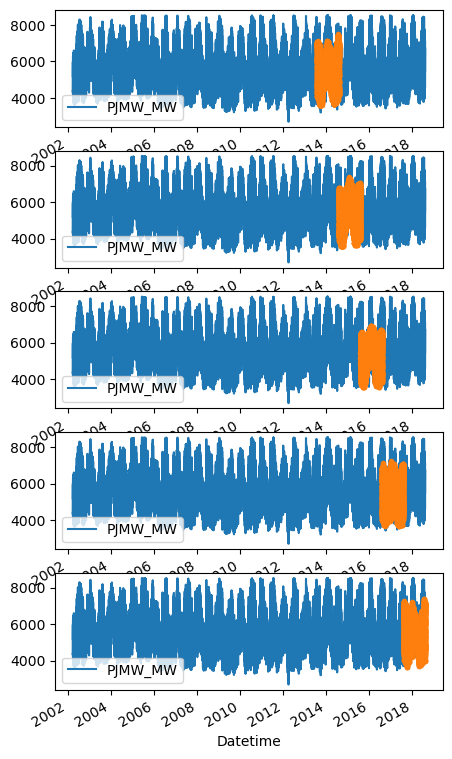

In [63]:
fig,axs=plt.subplots(5,figsize=(5,10))
df=df.sort_index()
cross_features=['year', 'month', 'day_of_week', 'day_of_year', 'quarter', 'hour','lag1','lag2','lag3']
all_features=cross_features+[target]
preds=[]
scores=[]
fold=0
for train_idx, val_idx in tss.split(df):
    plot_df=df[all_features].copy()
    train=df.iloc[train_idx]
    test=df.iloc[val_idx]
    X_train,y_train=train[cross_features],train[target]
    X_test,y_test=test[cross_features],test[target]
    
    model=xgb.XGBRegressor(booster='gbtree',
                           n_estimators=10000,
                           objective='reg:linear',
                           early_stopping_rounds=50,
                           learning_rate=0.001)
    model.fit(X_train,y_train,eval_set=[(X_train,y_train),(X_test,y_test)],verbose=100)
    y_pred=model.predict(X_test)
    test['xgb_prediction']=y_pred
    plot_df=plot_df.merge(test['xgb_prediction'],how='left',left_index=True,right_index=True)
    plot_df[[target]].plot(ax=axs[fold])
    plot_df['xgb_prediction'].plot(ax=axs[fold], style='.')
    
    fold+=1
    preds.append(y_pred)
    scores.append(np.sqrt(mean_squared_error(y_test,y_pred)))
plt.show()



In [65]:
print(f'Score across folds {np.mean(scores):0.2f}')
print(f'Fold scores:{scores}')

Score across folds 633.66
Fold scores:[597.6668774848763, 576.8590853698015, 612.8882910017795, 690.8933049487237, 689.9938751194875]
